# Проектная работа на тему:
## Сравнительное исследование алгоритмов ансамблирования моделей на примере задачи классификации

Содержание:
- Предварительная подготовка набора данных
- Базовый EDA
- Bagging + настройка на GridSearchCV
- Random Forest + настройка на GridSearchCV
- Gradient Boosting на примере catboost + настройка
- Сравнение итоговых результатов
- Выводы

In [1]:
import numpy as np 
import pandas as pd 
import seaborn as sns 
import matplotlib.ticker as mtick # For specifying the axes tick format 
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, classification_report
from sklearn.preprocessing import StandardScaler

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.model_selection import GridSearchCV

from catboost import CatBoostClassifier

import warnings
warnings.filterwarnings("ignore")

# Preprocessing

In [2]:
df = pd.read_csv('data/WA_Fn-UseC_-Telco-Customer-Churn.csv', index_col=0)

In [3]:
df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
customerID,,,,,,,,,,,,,,,,,,,,
7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7043 non-null   object 
 1   SeniorCitizen     7043 non-null   int64  
 2   Partner           7043 non-null   object 
 3   Dependents        7043 non-null   object 
 4   tenure            7043 non-null   int64  
 5   PhoneService      7043 non-null   object 
 6   MultipleLines     7043 non-null   object 
 7   InternetService   7043 non-null   object 
 8   OnlineSecurity    7043 non-null   object 
 9   OnlineBackup      7043 non-null   object 
 10  DeviceProtection  7043 non-null   object 
 11  TechSupport       7043 non-null   object 
 12  StreamingTV       7043 non-null   object 
 13  StreamingMovies   7043 non-null   object 
 14  Contract          7043 non-null   object 
 15  PaperlessBilling  7043 non-null   object 
 16  PaymentMethod     7043 non-null 

In [5]:
df.isna().sum()

gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

In [6]:
df.select_dtypes(include='object').columns

Index(['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines',
       'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract',
       'PaperlessBilling', 'PaymentMethod', 'TotalCharges', 'Churn'],
      dtype='object')

In [7]:
df.nunique()

gender                 2
SeniorCitizen          2
Partner                2
Dependents             2
tenure                73
PhoneService           2
MultipleLines          3
InternetService        3
OnlineSecurity         3
OnlineBackup           3
DeviceProtection       3
TechSupport            3
StreamingTV            3
StreamingMovies        3
Contract               3
PaperlessBilling       2
PaymentMethod          4
MonthlyCharges      1585
TotalCharges        6531
Churn                  2
dtype: int64

In [8]:
bin_obj_cols = ['gender','Partner','Dependents','PhoneService','PaperlessBilling','Churn']

In [9]:
for col in bin_obj_cols:
    print(col, df[col].unique())

gender ['Female' 'Male']
Partner ['Yes' 'No']
Dependents ['No' 'Yes']
PhoneService ['No' 'Yes']
PaperlessBilling ['Yes' 'No']
Churn ['No' 'Yes']


In [10]:
g_dict = {'Female':0, 'Male':1}

In [11]:
df['gender'] = df['gender'].map(g_dict)

In [12]:
yn_dict = {'Yes':1, 'No':0}

In [13]:
for col in bin_obj_cols[1:]:
    df[col] = df[col].map(yn_dict)

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7043 non-null   int64  
 1   SeniorCitizen     7043 non-null   int64  
 2   Partner           7043 non-null   int64  
 3   Dependents        7043 non-null   int64  
 4   tenure            7043 non-null   int64  
 5   PhoneService      7043 non-null   int64  
 6   MultipleLines     7043 non-null   object 
 7   InternetService   7043 non-null   object 
 8   OnlineSecurity    7043 non-null   object 
 9   OnlineBackup      7043 non-null   object 
 10  DeviceProtection  7043 non-null   object 
 11  TechSupport       7043 non-null   object 
 12  StreamingTV       7043 non-null   object 
 13  StreamingMovies   7043 non-null   object 
 14  Contract          7043 non-null   object 
 15  PaperlessBilling  7043 non-null   int64  
 16  PaymentMethod     7043 non-null 

Приведем признак TotalCharges к типу float

In [15]:
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

In [16]:
df.isna().sum()

gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64

Видим, что есть 11 пропущенных значений в Total Charges, записей немного, поэтому, просто удалим их из набора данных

In [17]:
df.dropna(inplace = True)

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7032 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7032 non-null   int64  
 1   SeniorCitizen     7032 non-null   int64  
 2   Partner           7032 non-null   int64  
 3   Dependents        7032 non-null   int64  
 4   tenure            7032 non-null   int64  
 5   PhoneService      7032 non-null   int64  
 6   MultipleLines     7032 non-null   object 
 7   InternetService   7032 non-null   object 
 8   OnlineSecurity    7032 non-null   object 
 9   OnlineBackup      7032 non-null   object 
 10  DeviceProtection  7032 non-null   object 
 11  TechSupport       7032 non-null   object 
 12  StreamingTV       7032 non-null   object 
 13  StreamingMovies   7032 non-null   object 
 14  Contract          7032 non-null   object 
 15  PaperlessBilling  7032 non-null   int64  
 16  PaymentMethod     7032 non-null 

Преобразуем оставшиеся категориальные признаки, применив OneHotEncoding 

In [19]:
obj_cols = df.select_dtypes(include='object').columns

In [20]:
obj_cols

Index(['MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
       'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
       'Contract', 'PaymentMethod'],
      dtype='object')

In [21]:
for col in obj_cols:
    print(col, df[col].unique())

MultipleLines ['No phone service' 'No' 'Yes']
InternetService ['DSL' 'Fiber optic' 'No']
OnlineSecurity ['No' 'Yes' 'No internet service']
OnlineBackup ['Yes' 'No' 'No internet service']
DeviceProtection ['No' 'Yes' 'No internet service']
TechSupport ['No' 'Yes' 'No internet service']
StreamingTV ['No' 'Yes' 'No internet service']
StreamingMovies ['No' 'Yes' 'No internet service']
Contract ['Month-to-month' 'One year' 'Two year']
PaymentMethod ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']


In [22]:
df = pd.get_dummies(df, columns=obj_cols, dtype='int64')

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7032 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 41 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   gender                                   7032 non-null   int64  
 1   SeniorCitizen                            7032 non-null   int64  
 2   Partner                                  7032 non-null   int64  
 3   Dependents                               7032 non-null   int64  
 4   tenure                                   7032 non-null   int64  
 5   PhoneService                             7032 non-null   int64  
 6   PaperlessBilling                         7032 non-null   int64  
 7   MonthlyCharges                           7032 non-null   float64
 8   TotalCharges                             7032 non-null   float64
 9   Churn                                    7032 non-null   int64  
 10  MultipleLines_No                      

# EDA

### Correlation of Churn with other variables:

<Axes: >

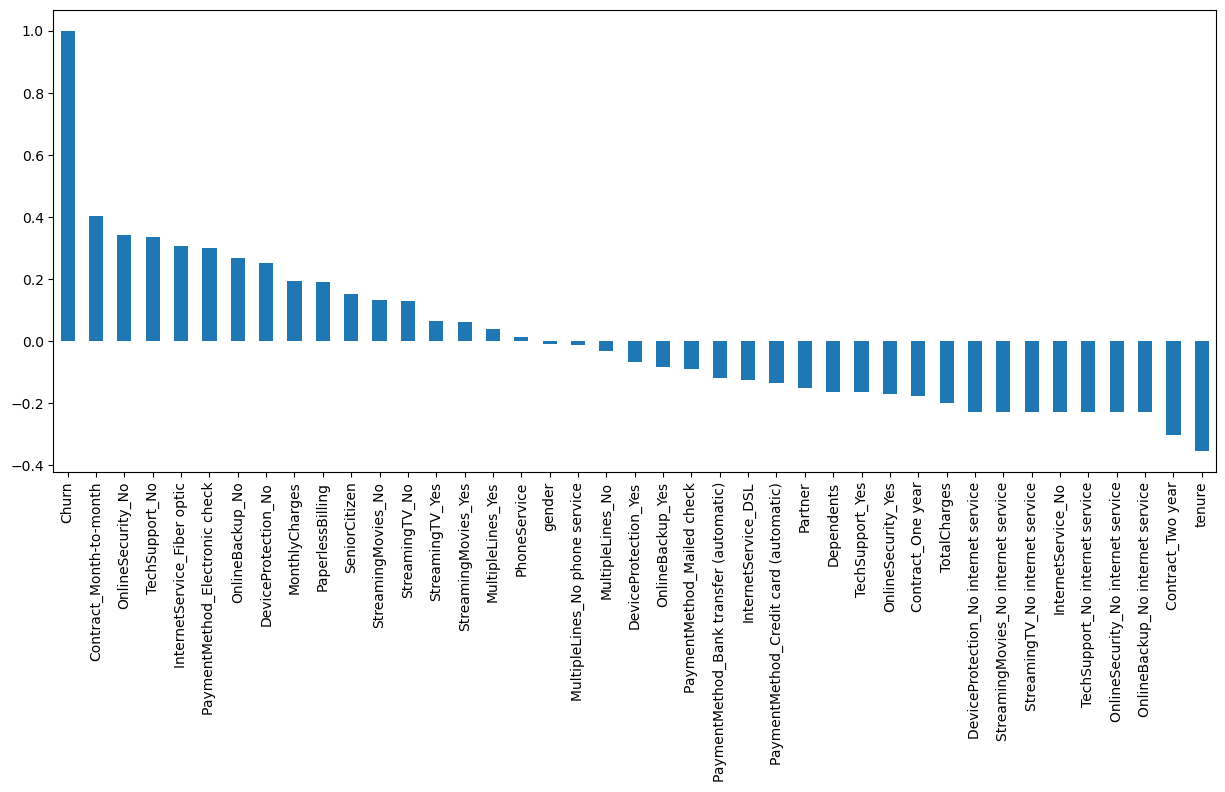

In [24]:
plt.figure(figsize=(15,6))
df.corr()['Churn'].sort_values(ascending = False).plot(kind='bar')

### Numerical Features vs Target Variable (Churn)

Посмотрим на распределение числовых признаков

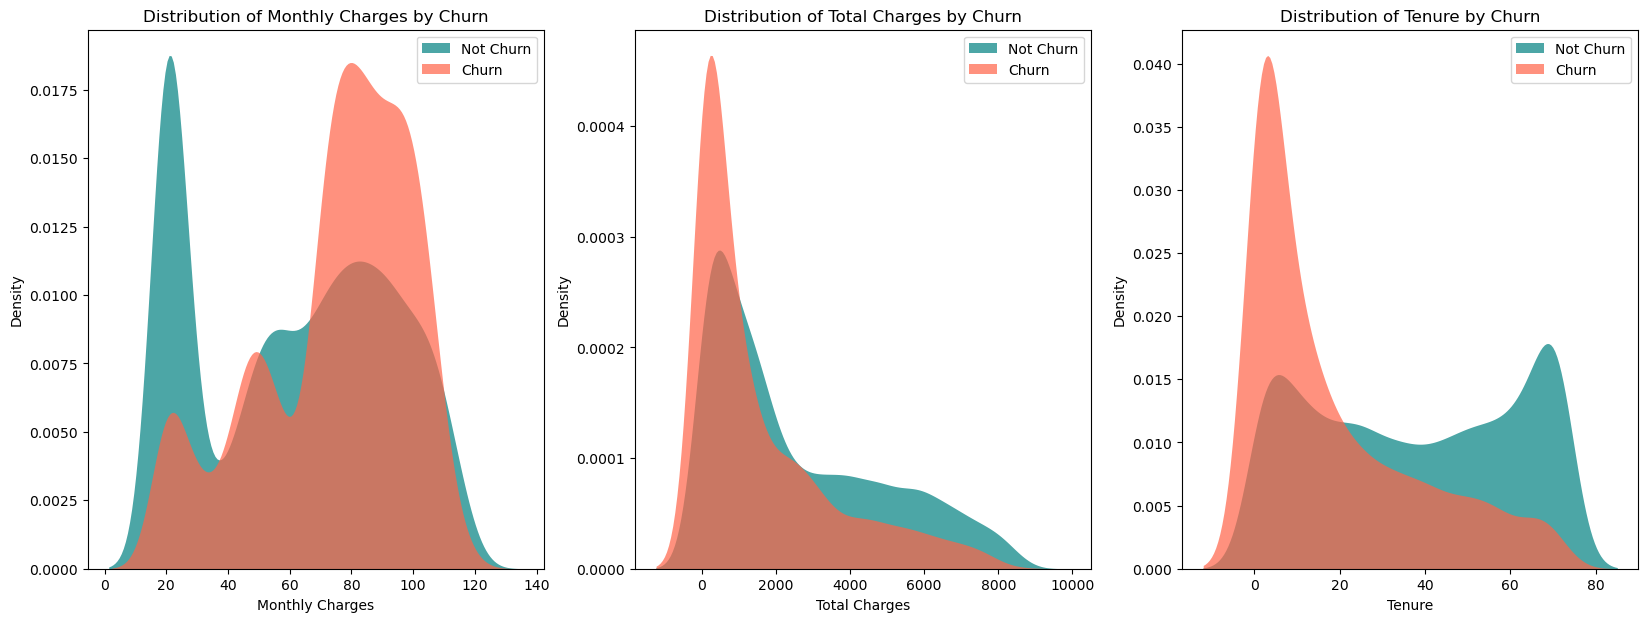

In [25]:
fig = plt.subplots(nrows = 1,ncols = 3,figsize = (20,7))

plt.subplot(1,3,1)
ax = sns.kdeplot(df.MonthlyCharges[(df["Churn"] == 0)], color='#008080', fill= True, alpha=.7, linewidth=0)
ax = sns.kdeplot(df.MonthlyCharges[(df["Churn"] == 1)], color='#FF6347', fill= True, alpha=.7, linewidth=0)
ax.legend(["Not Churn","Churn"],loc='upper right')
ax.set_ylabel('Density')
ax.set_xlabel('Monthly Charges')
ax.set_title('Distribution of Monthly Charges by Churn')

plt.subplot(1,3,2)
ax = sns.kdeplot(df.TotalCharges[(df["Churn"] == 0)], color='#008080', fill= True, alpha=.7, linewidth=0)
ax = sns.kdeplot(df.TotalCharges[(df["Churn"] == 1)], color='#FF6347', fill= True, alpha=.7, linewidth=0)
ax.legend(["Not Churn","Churn"],loc='upper right')
ax.set_ylabel('Density')
ax.set_xlabel('Total Charges')
ax.set_title('Distribution of Total Charges by Churn')

plt.subplot(1,3,3)
ax = sns.kdeplot(df.tenure[(df["Churn"] == 0)], color='#008080', fill= True, alpha=.7, linewidth=0)
ax = sns.kdeplot(df.tenure[(df["Churn"] == 1)], color='#FF6347', fill= True, alpha=.7, linewidth=0)
ax.legend(["Not Churn","Churn"],loc='upper right')
ax.set_ylabel('Density')
ax.set_xlabel('Tenure')
ax.set_title('Distribution of Tenure by Churn')

plt.show()

И также посмотрим на распределение целевой переменной

In [26]:
#Defining colors for the plots
palette = ['#008080','#FF6347', '#E50000', '#D2691E']

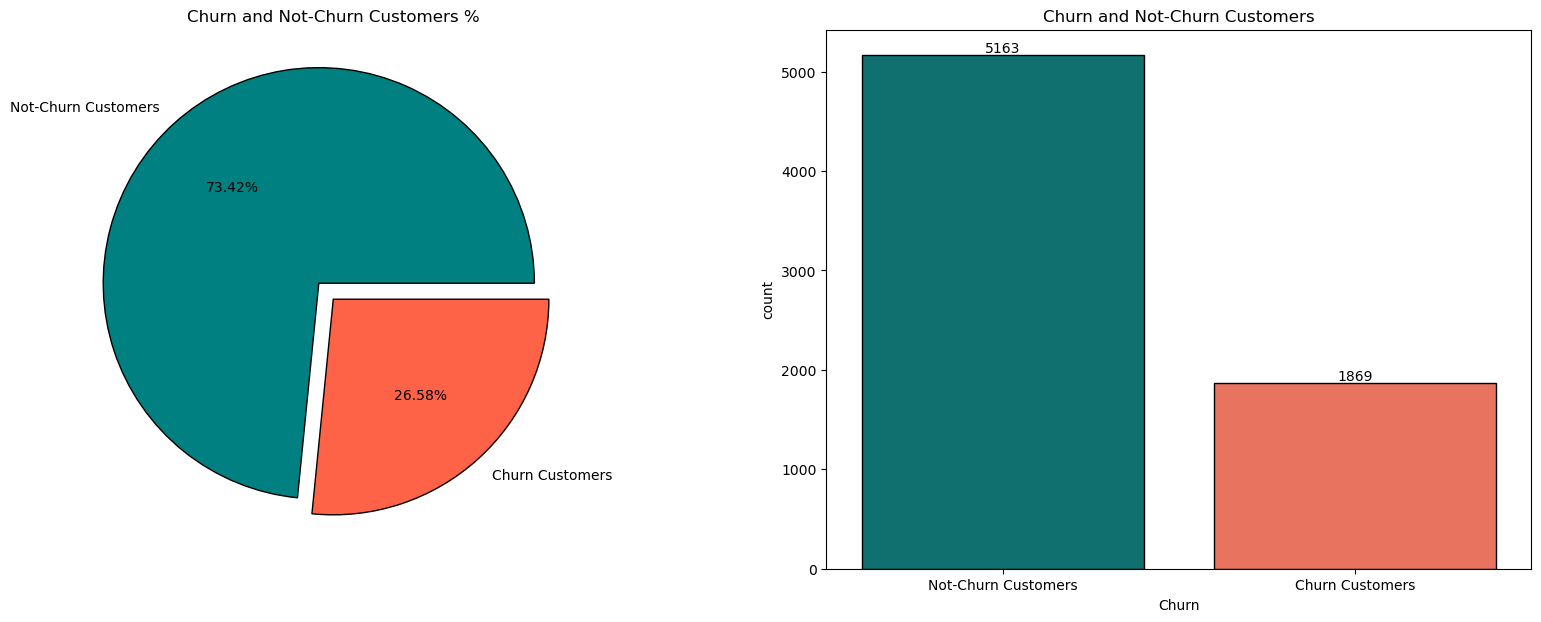

In [27]:
l1 = list(df['Churn'].value_counts())
pie_values = [l1[0] / sum(l1) * 100, l1[1] / sum(l1) * 100]

fig = plt.subplots(nrows = 1,ncols = 2,figsize = (20,7))

plt.subplot(1,2,1)
plt.pie(pie_values,labels = ['Not-Churn Customers','Churn Customers'], 
        autopct = '%1.2f%%',
        explode = (0.1,0),
        colors = palette,
        wedgeprops = {'edgecolor': 'black','linewidth': 1, 'antialiased' : True})
plt.title('Churn and Not-Churn Customers %');

plt.subplot(1,2,2)
ax = sns.countplot(data = df, 
                   x='Churn',
                   palette = palette, 
                   edgecolor = 'black')
for i in ax.containers:
    ax.bar_label(i,)
ax.set_xticklabels(['Not-Churn Customers','Churn Customers'])
    
plt.title('Churn and Not-Churn Customers')
plt.show()

Значение целевой переменной несбалансировано с соотношением ~ 1:4 - необходимо использовать параметр stratify при разделении набора данных на обучающую и тестовую выборки

# Feature Engineering

### Train test split - stratified splitting

In [28]:
X = df.drop('Churn', axis=1)
y = df['Churn']

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size = 0.3, random_state = 13)

### Feature scaling

In [30]:
numeric_columns = ['tenure', 'MonthlyCharges', 'TotalCharges']

In [31]:
std_scaler = StandardScaler()

In [32]:
X_train[numeric_columns] = std_scaler.fit_transform(X_train[numeric_columns])

In [33]:
X_test[numeric_columns]= std_scaler.transform(X_test[numeric_columns])

# Bagging

Defining a function to evalute quality metrics

In [34]:
def quality(true_y, prediction_y):
    """
    Evaluates and returns the following metrics: Accuracy, Precision, Recall, F1-score, AUC
    """
    accuracy = round(accuracy_score(true_y, prediction_y), 3)
    precision = round(precision_score(true_y, prediction_y), 3)
    recall = round(recall_score(true_y, prediction_y), 3)
    f1 = round(f1_score(true_y, prediction_y), 3)
    auc = round(roc_auc_score(true_y, prediction_y), 3)
    print(f" Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"   Recall: {recall}")
    print(f" F1-score: {f1}")
    print(f"      AUC: {auc}")
    return [accuracy, precision, recall, f1, auc]

In [35]:
results = {}

In [36]:
bag_clf = BaggingClassifier(estimator=DecisionTreeClassifier(max_depth=5), n_jobs=-1, n_estimators=10, random_state=13)

In [37]:
bag_clf.fit(X_train, y_train)

BaggingClassifier(estimator=DecisionTreeClassifier(max_depth=5), n_jobs=-1,
                  random_state=13)

In [38]:
y_pred = bag_clf.predict(X_test)

In [39]:
results['Bagging'] = quality(y_test, y_pred)

 Accuracy: 0.785
Precision: 0.629
   Recall: 0.465
 F1-score: 0.535
      AUC: 0.683


## GridSearch

In [40]:
# Define Decision Tree classifier with default parameters
clf = BaggingClassifier(estimator=DecisionTreeClassifier(max_depth=5), n_jobs=-1, random_state=13)

# Estimate grid of the classifier hyperparameters
parameters = {'n_estimators':[10,20,30,50,100]}

# Define GridSearch parameters
gs = GridSearchCV(clf,                 # Classifier object to optimize
                  parameters,          # Grid of the hyperparameters
                  scoring='recall',    # Claasification quality metric to optimize
                  cv=5)                # Number of folds in KFolds cross-validation (CV)


# Run Grid Search optimization
gs.fit(X_train, y_train)
gs.best_params_

{'n_estimators': 20}

In [41]:
pred_bggs = gs.predict(X_test)

In [42]:
results['Bagging-GS'] = quality(y_test, pred_bggs)

 Accuracy: 0.787
Precision: 0.637
   Recall: 0.465
 F1-score: 0.538
      AUC: 0.685


In [43]:
pd.DataFrame(results, index = ['Accuracy', 'Precision', 'Recall', 'F1-score', 'AUC']).T

,Accuracy,Precision,Recall,F1-score,AUC
Bagging,0.785,0.629,0.465,0.535,0.683
Bagging-GS,0.787,0.637,0.465,0.538,0.685


# Random Forest

In [44]:
rf_clf = RandomForestClassifier(n_estimators=500, n_jobs=-1, max_depth = None, random_state=13)

In [45]:
rf_clf.fit(X_train, y_train)

RandomForestClassifier(n_estimators=500, n_jobs=-1, random_state=13)

In [46]:
y_pred = rf_clf.predict(X_test)

In [47]:
results['Random Forest'] = quality(y_test, y_pred)

 Accuracy: 0.793
Precision: 0.642
   Recall: 0.499
 F1-score: 0.562
      AUC: 0.699


In [48]:
pd.DataFrame(results, index = ['Accuracy', 'Precision', 'Recall', 'F1-score', 'AUC']).T

,Accuracy,Precision,Recall,F1-score,AUC
Bagging,0.785,0.629,0.465,0.535,0.683
Bagging-GS,0.787,0.637,0.465,0.538,0.685
Random Forest,0.793,0.642,0.499,0.562,0.699


## Feature importance

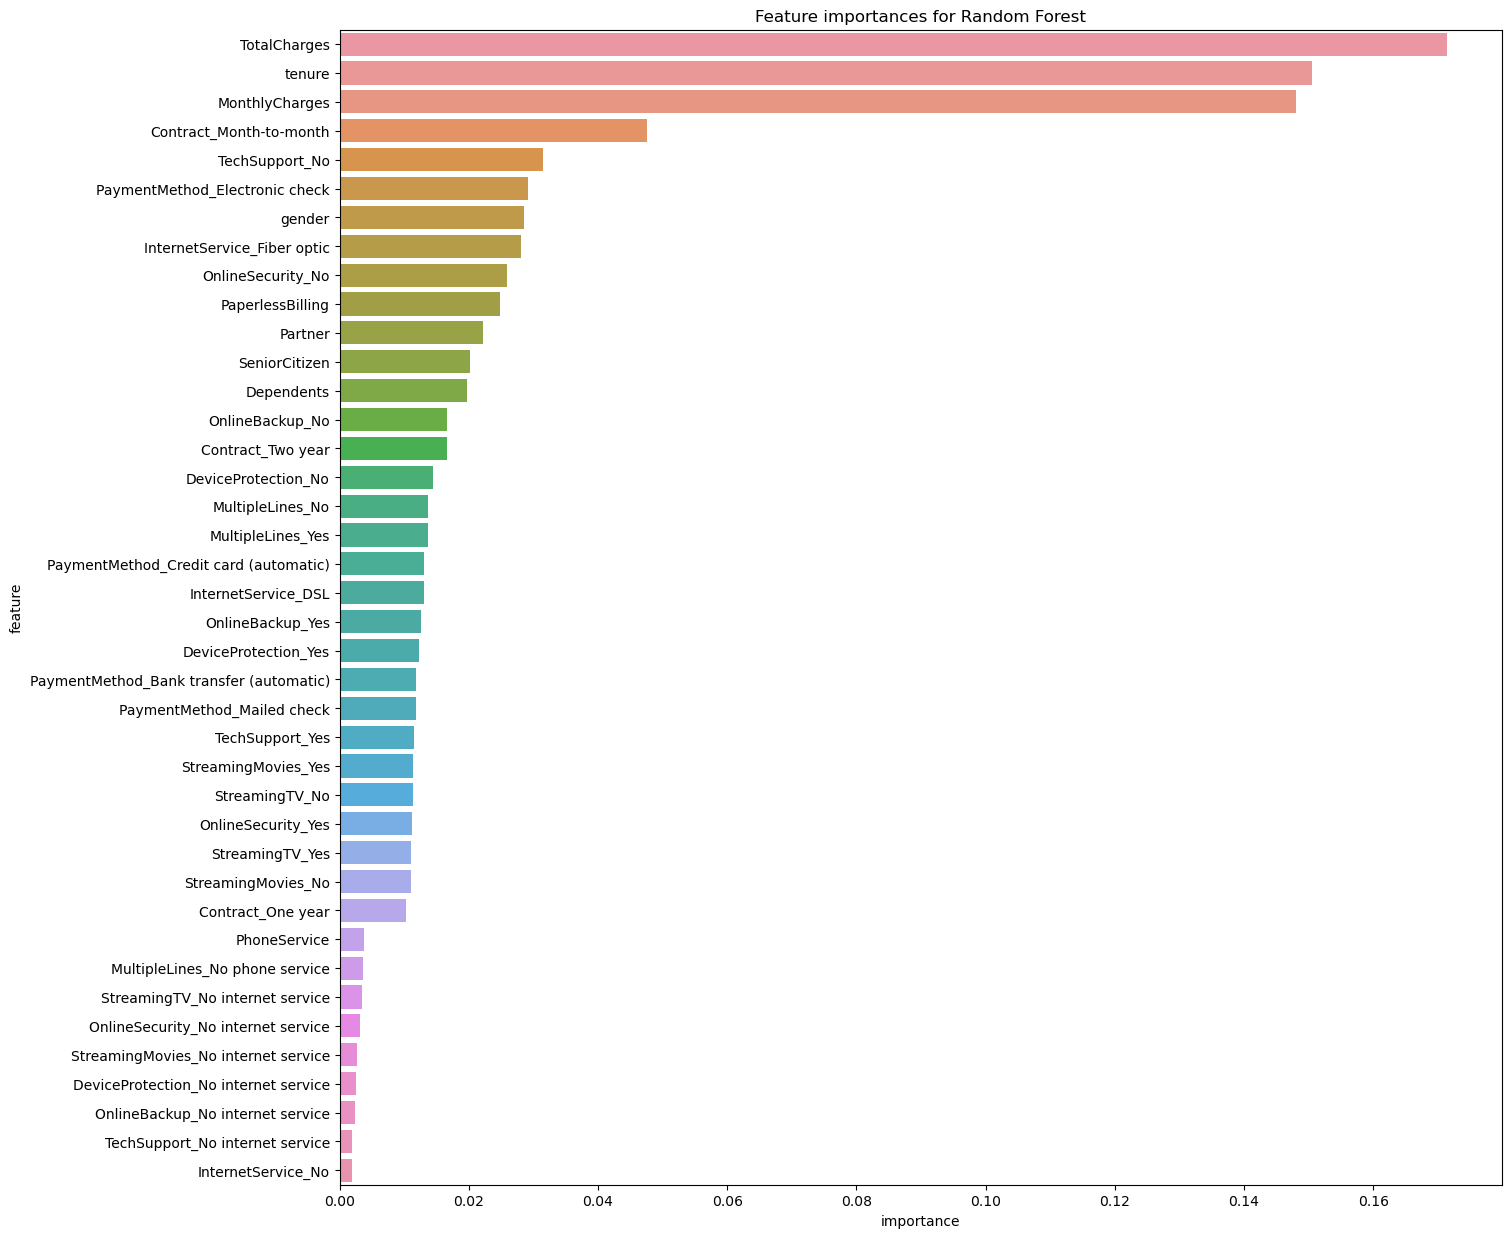

In [49]:
feature_importances = zip(X_train.columns, rf_clf.feature_importances_)
feature_importances = sorted(feature_importances, key=lambda x: x[1], reverse=True)
feature_importances = pd.DataFrame(feature_importances, columns=['feature', 'importance'])

plt.figure(figsize=(15,15))
plt.title('Feature importances for Random Forest')
sns.barplot(x='importance', y='feature', data=feature_importances)
plt.show()

## Tuning

In [50]:
parameters = {'n_estimators': [50, 100, 500], 'max_features' : [None, 5], 'max_depth':[None, 5, 10]}

model = RandomForestClassifier(random_state=13)
gs = GridSearchCV(model, parameters, scoring = 'recall')

gs.fit(X_train, y_train)
pred = gs.predict(X_test)
gs.best_params_

{'max_depth': 10, 'max_features': None, 'n_estimators': 100}

In [51]:
results['Random Forest-GS'] = quality(y_test, pred)

 Accuracy: 0.787
Precision: 0.628
   Recall: 0.488
 F1-score: 0.55
      AUC: 0.692


In [52]:
pd.DataFrame(results, index = ['Accuracy', 'Precision', 'Recall', 'F1-score', 'AUC']).T

,Accuracy,Precision,Recall,F1-score,AUC
Bagging,0.785,0.629,0.465,0.535,0.683
Bagging-GS,0.787,0.637,0.465,0.538,0.685
Random Forest,0.793,0.642,0.499,0.562,0.699
Random Forest-GS,0.787,0.628,0.488,0.550,0.692


# Gradient Boosting

In [53]:
catboost = CatBoostClassifier(iterations=5, logging_level='Silent', random_state=13)

In [54]:
catboost.fit(X_train, y_train)

In [55]:
pred = catboost.predict(X_test)

In [56]:
results['Catboost'] = quality(y_test, pred)

 Accuracy: 0.808
Precision: 0.688
   Recall: 0.506
 F1-score: 0.583
      AUC: 0.711


In [57]:
pd.DataFrame(results, index = ['Accuracy', 'Precision', 'Recall', 'F1-score', 'AUC']).T

,Accuracy,Precision,Recall,F1-score,AUC
Bagging,0.785,0.629,0.465,0.535,0.683
Bagging-GS,0.787,0.637,0.465,0.538,0.685
Random Forest,0.793,0.642,0.499,0.562,0.699
Random Forest-GS,0.787,0.628,0.488,0.550,0.692
Catboost,0.808,0.688,0.506,0.583,0.711


### Tuning

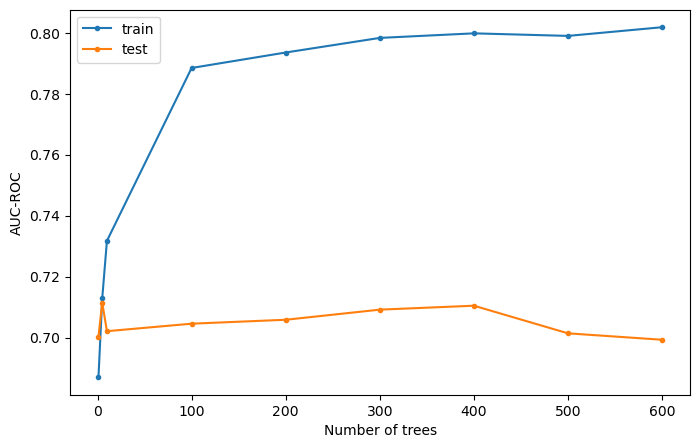

In [58]:
n_trees = [1, 5, 10, 100, 200, 300, 400, 500, 600]
quals_train = []
quals_test = []
for n in n_trees:
    clf = CatBoostClassifier(iterations=n, logging_level='Silent', random_state=13)
    clf.fit(X_train, y_train)
    q_train = roc_auc_score(y_train, clf.predict(X_train))
    q_test = roc_auc_score(y_test, clf.predict(X_test))

    quals_train.append(q_train)
    quals_test.append(q_test)

plt.figure(figsize=(8, 5))
plt.plot(n_trees, quals_train, marker='.', label='train')
plt.plot(n_trees, quals_test, marker='.', label='test')
plt.xlabel('Number of trees')
plt.ylabel('AUC-ROC')
plt.legend()

plt.show()

In [59]:
sorted(list(zip(quals_test, n_trees)), reverse=True)

[(0.711479661998023, 5),
 (0.7104485787507092, 400),
 (0.7091574231664612, 300),
 (0.7058380485828935, 200),
 (0.7045468929986456, 100),
 (0.7020900149484056, 10),
 (0.7013817205971538, 500),
 (0.7002971268911344, 1),
 (0.6992764005067958, 600)]

### Feature importance

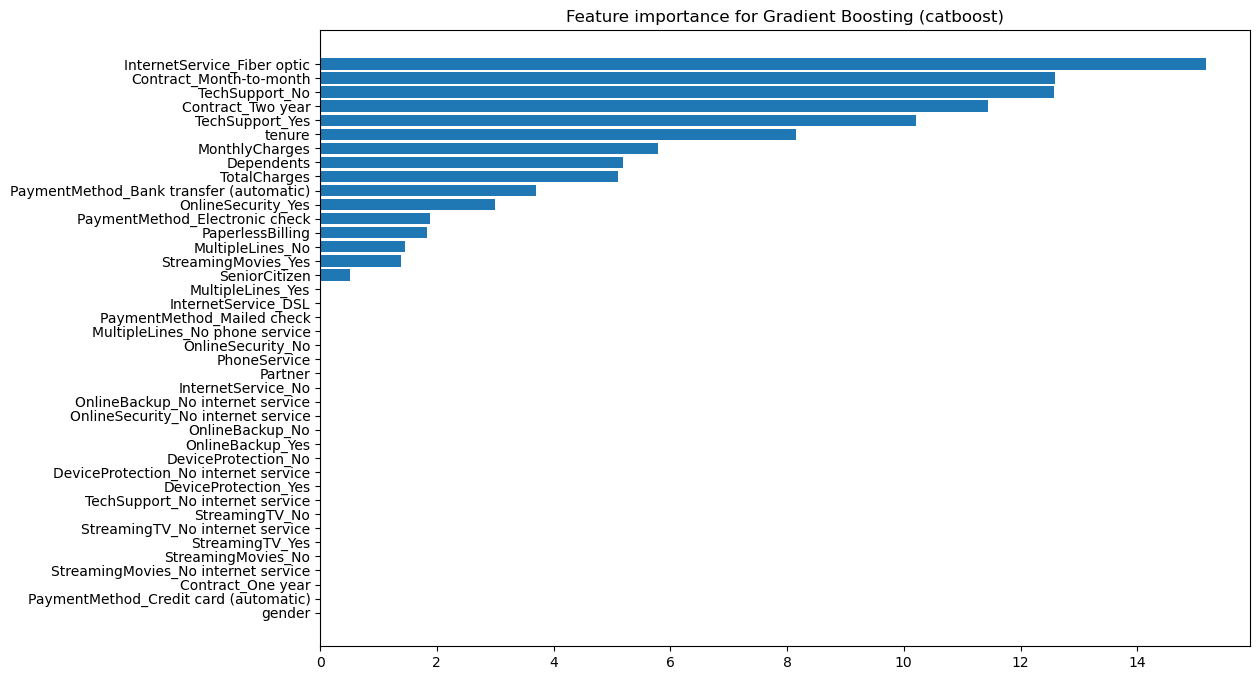

In [60]:
feature_importance = catboost.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 8))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_test.columns)[sorted_idx])
plt.title('Feature importance for Gradient Boosting (catboost)');

## Summary

In [61]:
pd.DataFrame(results, index = ['Accuracy', 'Precision', 'Recall', 'F1-score', 'AUC']).T

,Accuracy,Precision,Recall,F1-score,AUC
Bagging,0.785,0.629,0.465,0.535,0.683
Bagging-GS,0.787,0.637,0.465,0.538,0.685
Random Forest,0.793,0.642,0.499,0.562,0.699
Random Forest-GS,0.787,0.628,0.488,0.550,0.692
Catboost,0.808,0.688,0.506,0.583,0.711


### Visualisation

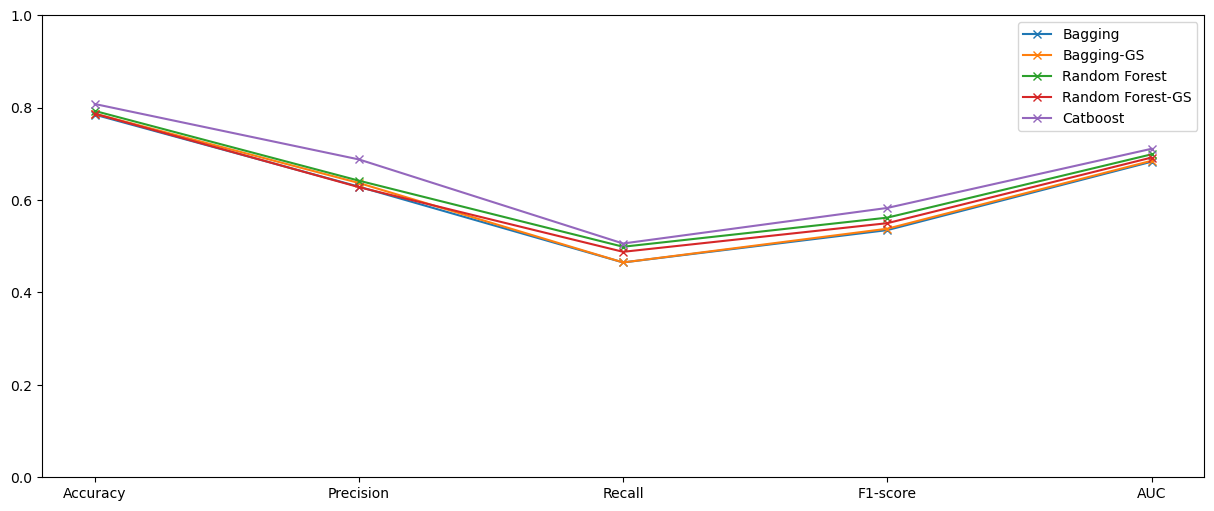

In [62]:
plt.figure(figsize=(15, 6))
x = np.arange(5)

for key, value in results.items():
    plt.plot(x, results[key], marker='x', label=key);
    
plt.xticks(x, ['Accuracy', 'Precision', 'Recall', 'F1-score', 'AUC']);
plt.ylim(0, 1)
plt.legend(prop ={'size': 10});

### Выводы

- Из трех алгоритмов ансамблирования наилучшие результаты ожидаемо продемонстрировал градиентный бустинг на примере реализации catboost;
- При этом, результаты всех алгоритмов достаточно близки, соответственно, выбирать нужно наиболее подходящий под конкретную задачу;
- Дополнительная тонкая настройка параметров может продемонстрировать более существенные различия в результатах;